# Retrieval Pipeline

This notebooks is continuation after uploading your documents to Azure AI Search. We will use Azure OpenAI and Langgraph to build an agent to retrieve the data and generate the answer.

In [1]:
# Prepare environment variable
# You should check env.example file
# It's needed throughout this jupyter notebook
import os
from dotenv import load_dotenv
load_dotenv()

True

## Prepare Connector

Before creating agent, we want to prepare the connector to Azure AI Search so that the model can use the AI Search. We will use langchain-community based connector for easier langgraph integration.

In [2]:
import langchain_community.vectorstores.azuresearch as azuresearch

from langchain_community.vectorstores.azuresearch import AzureSearch
from langchain_openai import AzureOpenAIEmbeddings

In [3]:
# Check if you already prepare the environment file
index_name = "kaenova-testing-3" # You can change it, if you want to
api_version = "2024-12-01-preview"

for key in ["AZURE_AIS_ENDPOINT", "AZURE_AIS_KEY", "AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [4]:
# !important you may change this. Map the fields into the connector library
azuresearch.FIELDS_CONTENT = "chunk"
azuresearch.FIELDS_CONTENT_VECTOR = "chunk_vector"
azuresearch.FIELDS_ID = "id"

In [5]:
# Prepare the embedding function
embeddings : AzureOpenAIEmbeddings = AzureOpenAIEmbeddings(
    azure_deployment=os.getenv("AZURE_OAI_DEPLOYMENT"),
    openai_api_version=api_version,
    azure_endpoint=os.getenv("AZURE_OAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OAI_KEY"),
)

embeddings_function = embeddings.embed_query

In [6]:
# Create Azure AI Search client
vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=os.getenv("AZURE_AIS_ENDPOINT"),
    azure_search_key=os.getenv("AZURE_AIS_KEY"),
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

In [7]:
docs = vector_store.semantic_hybrid_search(
    query="Tahun Gerakan Perempuan", k=1,
)
print(docs[0])

page_content='banyak kelompok yang memiliki massa, baik yang berbasis ideologi 
politik maupun agama. Kekuatan kelompok tersebut memunculkan warna 
yang beragam pada identitas nasional dan berbagai peristiwa sejarah di 
Indonesia. Beberapa di antaranya akan dibahas pada subbab berikut.
1.	 Gerakan Perempuan 
Gerakan Perempuan pada tahun 1950—1960 merupakan salah satu 
periode pergerakan paling progresif setelah tahun 1928. Pada periode ini 
banyak organisasi perempuan yang berafiliasi dengan kekuatan-kekuatan 
organisasi massa yang besar. Sebagai contoh Aisyiah dari Muhammadiyah, 
Muslimat dari Masyumi, Muslimat Nahdlatul Ulama (NU) dari NU, Perwari, 
dan juga Gerakan Wanita Istri Sedar (Gerwis). Gerwis merupakan gabungan 
dari ratusan aktivis dan berbagai organisasi perempuan, misalnya Rukun 
Putri Indonesia, Persatuan Wanita Sedar, Isteri Sedar, Gerakan Wanita 
Indonesia, dan Perjuangan Putri Republik Indonesia. Pada kongres pertama 
tahun 1951, Gerwis berubah nama menjadi Gerwani (G

## Prepare Agent

To maximize our search result, we're not only searching by one query, we need to expand user query into multiple query and search the best one

In [8]:
# Prepare library
## LLM related
import os
import json
from langchain.chat_models import init_chat_model

## State related
from typing import Annotated
from typing_extensions import TypedDict

## Graph Related
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, AnyMessage

## Graph Related Memory
# import sqlite3
# from langgraph.checkpoint.sqlite import SqliteSaver

In [9]:
# Check if you already prepare the environment file
api_version = "2024-12-01-preview"
langchain_model_name = "azure_openai:gpt-4" # Adjust based on what you deployed 

for key in ["AZURE_OAI_ENDPOINT", "AZURE_OAI_KEY", "AZURE_OAI_CHAT_DEPLOYMENT"]:
    if not os.getenv(key):
        raise ValueError(f"{key} is not provided")

In [10]:
# Prepare langgraph state 
class State(TypedDict):
    question: str # Saving the user questions
    agent_query: list[str] # Saving the expanded agent query, could be multiple query
    agent_query_answer: list[str] # Saving multiple unique relevance docs
    answer: str # Saving the summarizer answer

    messages: Annotated[list[AnyMessage], add_messages] # To keep chat threads

In [11]:
# Prepare LLM we're going to use

## Prepare langgraph llm initialization
os.environ["AZURE_OPENAI_API_KEY"] = os.getenv("AZURE_OAI_KEY")
os.environ["AZURE_OPENAI_ENDPOINT"] = os.getenv("AZURE_OAI_ENDPOINT")
os.environ["OPENAI_API_VERSION"] = api_version

chat_llm = init_chat_model(
    langchain_model_name,
    azure_deployment=os.environ["AZURE_OAI_CHAT_DEPLOYMENT"],
)

In [12]:
response = chat_llm.invoke([HumanMessage("Hello")])
response

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_5603ee5e2e', 'id': 'chatcmpl-CFelb5BjaEqBIlzosSSAlqRgBpsNs', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filtered': False, 'detected': False}, 'self

In [13]:
# Prepare function for each langgraph nodes
def expand_query(state: State):
    system_prompt = (
        "You're a search query expander, you'll get a user question and you need to create multiple concise, keyworded, and general search query"
        "That'll be injected to the Azure AI Search"
        "Return the question only in JSON array without any codeblocks"
        "You'll only return like \'[\"query_1\", \"query_2\", \"query_3\", \"query_4\", \"query_5\"]\'"
    )

    valid = False
    data = []
    while not valid:
        result = chat_llm.invoke([SystemMessage(content=system_prompt), HumanMessage(content=state["question"])])
        print("[expand_query] llm_result", result.content)
        
        try:
            data = json.loads(result.content)
            if type(data) is list:
                valid = True
        except:
            print("[expand_query] not a valid value")
    return {"agent_query": data, "messages": [HumanMessage(content=state["question"])]}

def retrieve_documents(state: State):
    retrieved_chunks = []
    for question in state["agent_query"]:
        answers = vector_store.semantic_hybrid_search(
            query=question, k=5,
        )
        for x in answers:
            retrieved_chunks.append(x.page_content)
    print("[retrieved_chunks] retrieved before set", len(retrieved_chunks), "of documents")
    final_chunks = list(set(retrieved_chunks))
    print("[retrieve_documents] retrieved", len(final_chunks), "of documents")
    return {"agent_query_answer": final_chunks}

def summarize(state: State):
    system_prompt = (
        "You're a search questions and answer summarizer"
        "You'll be given a multiple related documents, try to answer based on the documents given"
        "Articulate the questions first and then if the questions is not related based on the relevance documents,"
        "Let the user know that you're not entirely sure"
        "Be sure to answer with user question language"
    )

    human_prompt_template = (
        "Here are related documents"
        "{documents}"
        "\n"
        "Here are my questions"
        "{question}"
    )

    prepared_documents_prompt = []
    for i, doc in enumerate(state["agent_query_answer"]):
        prepared_documents_prompt.append(f"# Document {i+1}\n```{doc}```")

    documents_prompt = "\n".join(prepared_documents_prompt)

    human_prompt = human_prompt_template.format(documents=documents_prompt, question=state["question"])

    # Add to message threads
    state["messages"].append(SystemMessage(content=system_prompt))
    state["messages"].append(HumanMessage(content=human_prompt))

    chat_res = chat_llm.invoke(state["messages"])

    print(f"[summarize]", chat_res.content)

    return {"messages": [chat_res]}

In [14]:
# Create and connect the graph
# Define graph
graph_builder = StateGraph(State)

# Define nodes
graph_builder.add_node("query_expander", expand_query)
graph_builder.add_node("retriever", retrieve_documents)
graph_builder.add_node("summarizer", summarize)

# Define Edges
graph_builder.add_edge(START, "query_expander")
graph_builder.add_edge("query_expander", "retriever")
graph_builder.add_edge("retriever", "summarizer")
graph_builder.add_edge("summarizer", END)


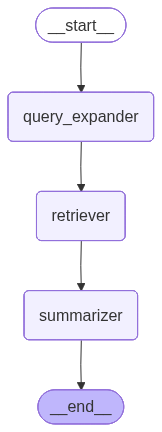

In [15]:
# Prepare checkpointer
# conn = sqlite3.connect("checkpoints.sqlite", check_same_thread=False)
# memory = SqliteSaver(conn)

# Not using checkpointer on langgraph cloud
# graph = graph_builder.compile(checkpointer=memory)
graph = graph_builder.compile()
display(graph)

# Let's Test The Retrieving Capability

In [17]:
# Session 1
chat_id = "unique-id-01"
config = {"configurable": {"thread_id": chat_id}}

while True:
    user_input = input("> ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    graph.invoke({"question": user_input}, config=config)

>  Kapan Gerakan Perempuan?


[expand_query] llm_result ["Sejarah Gerakan Perempuan Indonesia", "Tahun awal Gerakan Perempuan", "Kronologi perkembangan Gerakan Perempuan", "Milestone penting Gerakan Perempuan", "Kapan mulai Gerakan Emansipasi Perempuan"]
[retrieved_chunks] retrieved before set 25 of documents
[retrieve_documents] retrieved 6 of documents
[summarize] Gerakan Perempuan di Indonesia memiliki berbagai tonggak penting yang mencakup beberapa periode:

1. Periode paling progresif setelah tahun 1928 terjadi antara tahun 1950—1960, di mana banyak organisasi perempuan berafiliasi dengan kekuatan-kekuatan organisasi massa yang besar (Document 3).

2. Gerakan Wanita Istri Sedar (Gerwis) berubah nama menjadi Gerakan Wanita Indonesia (Gerwani) pada kongres pertama tahun 1951 (Document 3).

3. Gerakan perempuan pada masa Orde Baru mengalami sentralisasi di bawah Kongres Wanita Indonesia (Kowani) dan dipaksa mendukung tujuan pembangunan pemerintah (Document 1).

Dengan demikian, Gerakan Perempuan di Indonesia suda

>  Apa itu gerakan perempuan?


[expand_query] llm_result ["definisi gerakan perempuan", "sejarah gerakan perempuan", "tujuan gerakan perempuan", "pengaruh gerakan perempuan", "contoh gerakan perempuan"]
[retrieved_chunks] retrieved before set 25 of documents
[retrieve_documents] retrieved 6 of documents
[summarize] Gerakan perempuan didefinisikan sebagai usaha kolektif dan terorganisasi yang dilakukan oleh individu-individu atau kelompok untuk memajukan kondisi, status, dan hak-hak perempuan dalam masyarakat. Gerakan ini bertujuan untuk mengatasi isu-isu kritis yang dihadapi perempuan, termasuk ketidakadilan gender, diskriminasi, akses terhadap pendidikan, dan hak-hak reproduksi.

Dari dokumen yang tersedia, gerakan perempuan di Indonesia telah meliputi pembentukan organisasi seperti Aisyiah dari Muhammadiyah, Muslimat dari Masyumi, dan Muslimat Nahdlatul Ulama (NU), serta Gerakan Wanita Istri Sedar (Gerwis) yang kemudian bertransformasi menjadi Gerakan Wanita Indonesia (Gerwani). Kegiatan gerakan ini meliputi advok

>  q


Goodbye!


# What's next?

This retrieving process should be as a tool and a function, where if the chatboot needed it can use it, but if not needed, the chat can be varies topic generally